In [117]:
import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt


### Load Skeletons Data

In [118]:
skeldata_complete = sio.loadmat('girosmallveryslow2_openpose_complete.mat')['skeldata']
skeldata_incomplete = sio.loadmat('girosmallveryslow2_openpose.mat')['skeldata']
#features = sio.loadmat('girosmallveryslow2.mp4_features.mat')['features']

### Obtaining the data matrix

In [119]:
# Extract skeleton coordinates from skeleton data
poses = np.zeros((36, skeldata_incomplete.shape[1]))
poses[0::2, :] = skeldata_incomplete[1::3, :]
poses[1::2, :] = skeldata_incomplete[2::3, :]
scores = skeldata_incomplete[3::3, :]
frames = skeldata_incomplete[0, :]
# Obtain row and column size
rows = poses.shape[0]
columns = skeldata_incomplete.shape[1]
print(rows)
print(columns)

36
20793


In [120]:
# Obtain mask of visible coordinates
mask_visible = np.zeros((36, columns))
for k in range(rows):
    for l in range(columns):
        if poses[k, l] != 0:
            mask_visible[k, l] = 1

### Perform singular value decomposition

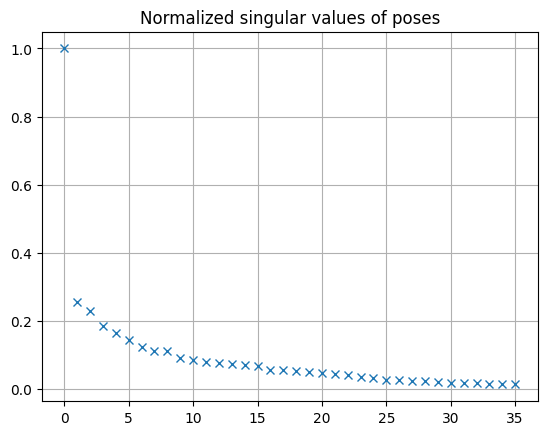

In [121]:
_, S, _ = np.linalg.svd(poses, full_matrices=False)

# Plot singular values
plt.figure()
plt.plot(S / S[0], 'x')
plt.grid(True)
plt.title('Normalized singular values of poses')
plt.show()

The magnitude of the singular values represents their importance in capturing the variability or energy of the original data. Larger singular values correspond to more significant patterns or structures in the data.

The steep initial drop followed by the slow decay indicates that a few singular values capture most of the variability in the data. This suggests that the data might be well-represented by a lower-rank approximation.

### Visualize visible coordinates of skeletons


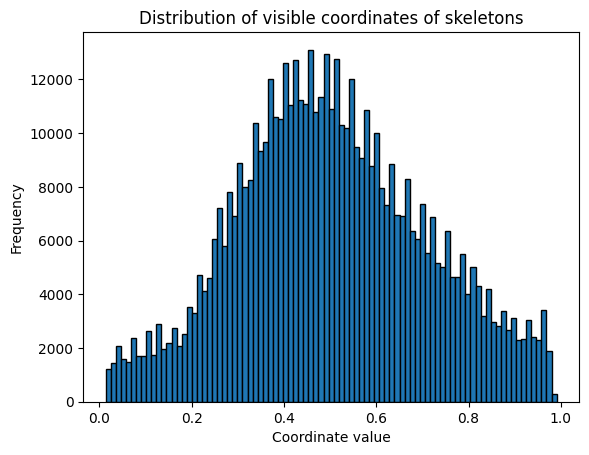

In [122]:
aux = poses.copy()
aux[poses == 0] = np.nan

plt.figure()
bin_edges = np.linspace(np.nanmin(aux), np.nanmax(aux), 90)  # Adjust the number of bins if needed
plt.hist(aux.flatten(), bins=bin_edges, edgecolor='black')
plt.title('Distribution of visible coordinates of skeletons')
plt.xlabel('Coordinate value')
plt.ylabel('Frequency')
plt.show()

The symmetric distribution with a single peak suggests that the majority of skeleton positions have coordinate values concentrated around a specific range. Though the tall extremities can suggest the presence of outliers in the data. 

Because the histogram represents the position of the points, than maybe the centered skeletons by a fixed point will enhance the normalike distribution of the histogram by fixing the high bars at the outer edges of the distribution

### Create bar graph of visible skeleton coordinates

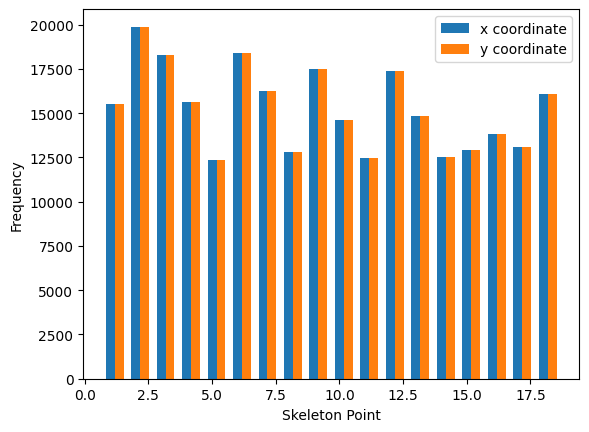

In [123]:
# Calculate frequencies for x and y coordinates
freqs_x = np.sum(mask_visible[0::2, :], axis=1)
freqs_y = np.sum(mask_visible[1::2, :], axis=1)

# Create bar graph
plt.figure()
x = np.arange(1, 19)
bar_width = 0.35

plt.bar(x, freqs_x, width=bar_width, label='x coordinate')
plt.bar(x + bar_width, freqs_y, width=bar_width, label='y coordinate')

plt.xlabel('Skeleton Point')
plt.ylabel('Frequency')
plt.legend()
plt.show()

The plot allows you to assess the completeness of the data by examining the frequency of existence coordinate across all skeletons. 
The points with higher frequency are present the most in skeletons and it indicates that the data for that point is relatively complete and reliable.

The points [2 3 4] and [5 6 7] corresponde to the two arms and have a relative siilarity in frequence which makes sense. The same can be scene for the points corresponding to the two legs, [8 9 10] and [11 12 13].

The points corresponding to the head have all very similar frequencies, which makes sense since the head is usually all in frame.

There is in general a slight asymmetry between left and right points, as the right side seems to have higher frequency than the left, which by analysing the frames we find that most of the "shots" favor the right side.


### Find skeletons with zero missing coordinates

In [124]:
k = 0
num_missing = np.zeros(columns)
full_skeletons = np.zeros((36, columns))

for i in range(columns):
    num_missing[i] = np.count_nonzero(np.logical_not(poses[:, i]))
    if num_missing[i] == 0:
        full_skeletons[:, k] = poses[:, i]
        k += 1
k

3216

### Visualize number of missing coordinates

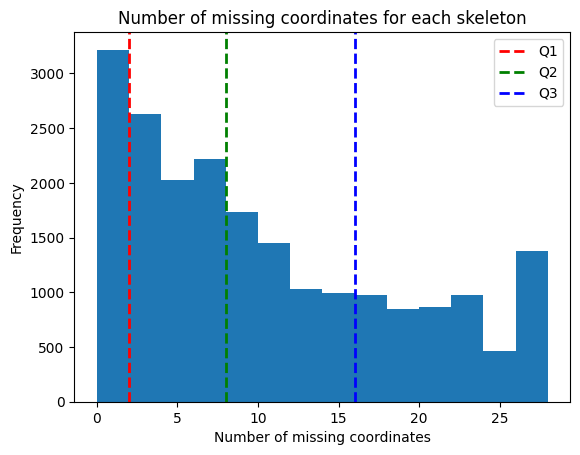

In [125]:
# Calculate quartiles
q1 = np.percentile(num_missing, 25)
q2 = np.percentile(num_missing, 50)
q3 = np.percentile(num_missing, 75)

# Plot histogram with quartiles
plt.figure()
plt.hist(num_missing, bins=14)
plt.axvline(q1, color='red', linestyle='dashed', linewidth=2, label='Q1')
plt.axvline(q2, color='green', linestyle='dashed', linewidth=2, label='Q2')
plt.axvline(q3, color='blue', linestyle='dashed', linewidth=2, label='Q3')

plt.title('Number of missing coordinates for each skeleton')
plt.xlabel('Number of missing coordinates')
plt.ylabel('Frequency')
plt.legend()
plt.show()

The histogram allows you to assess the overall data completeness by examining the frequency distribution of the number of missing coordinates. The graph shows that in fact the majority of the skeletons has more than half of the points assigned.